# hospital data curation project
## phase 9: decision tree classification - readmission prediction

objective: classify whether a patient is likely to be readmitted within 30 days

models: decision tree, random forest, gradient boosted trees

evaluation: accuracy, precision, recall, f1-score, auc, confusion matrix, roc curve

In [1]:
# import required libraries
import sys
import os
from pathlib import Path

# add src directory to python path
notebook_dir = Path(os.getcwd())
src_dir = notebook_dir / 'src'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve)
import joblib

# import project modules
import config
import utils

# use imported modules
PREPROCESSED_DATA_DIR = config.PREPROCESSED_DATA_DIR
MODELS_DIR = config.MODELS_DIR
VISUALIZATIONS_DIR = config.VISUALIZATIONS_DIR
RANDOM_SEED = config.RANDOM_SEED
setup_logging = utils.setup_logging
print_section_header = utils.print_section_header
load_dataframe = utils.load_dataframe


## 1. load and prepare data

In [2]:
# setup
logger = setup_logging()
np.random.seed(RANDOM_SEED)

# load transformed dataset
print_section_header("loading data for classification")

master_df = load_dataframe(PREPROCESSED_DATA_DIR / 'transformed_master_dataset.csv')

print(f"dataset loaded: {len(master_df)} rows, {len(master_df.columns)} columns")

2025-11-10 17:57:06,987 - root - INFO - loaded dataframe from d:\Github Desktop\Python\Hospital Data Curation\data\preprocessed\transformed_master_dataset.csv: 2481 rows, 36 columns



                        loading data for classification                         

dataset loaded: 2481 rows, 36 columns


## 2. feature selection for classification

In [3]:
# select features for predicting readmission
print_section_header("feature selection")

# target variable
target = 'is_readmitted'

# check if target exists
if target not in master_df.columns:
    print(f"error: target variable '{target}' not found in dataset")
    print(f"available columns: {list(master_df.columns)}")
else:
    # predictor features
    feature_columns = []
    
    # demographic features
    if 'age' in master_df.columns:
        feature_columns.append('age')
    
    if 'gender' in master_df.columns:
        # encode gender if not already done
        if master_df['gender'].dtype == 'object':
            master_df['gender_encoded'] = master_df['gender'].map({'Male': 1, 'Female': 0, 'Other': 2}).fillna(0)
            feature_columns.append('gender_encoded')
        else:
            feature_columns.append('gender')
    
    # clinical features
    if 'length_of_stay' in master_df.columns:
        feature_columns.append('length_of_stay')
    
    if 'diagnosis_count' in master_df.columns:
        feature_columns.append('diagnosis_count')
    
    if 'medication_count' in master_df.columns:
        feature_columns.append('medication_count')
    
    # risk factors
    if 'is_high_risk' in master_df.columns:
        feature_columns.append('is_high_risk')
    
    # temporal features
    if 'is_weekend_admission' in master_df.columns:
        feature_columns.append('is_weekend_admission')
    
    if 'admission_month' in master_df.columns:
        feature_columns.append('admission_month')
    
    # age group (encoded)
    if 'age_group' in master_df.columns:
        age_group_dummies = pd.get_dummies(master_df['age_group'], prefix='age_group')
        for col in age_group_dummies.columns:
            master_df[col] = age_group_dummies[col]
            feature_columns.append(col)
    
    print(f"selected features for classification:")
    for i, feature in enumerate(feature_columns, 1):
        print(f"  {i}. {feature}")
    
    print(f"\ntarget variable: {target}")
    
    # check class distribution
    class_dist = master_df[target].value_counts()
    print(f"\nclass distribution:")
    print(f"  not readmitted (0): {class_dist.get(0, 0)} ({class_dist.get(0, 0)/len(master_df)*100:.2f}%)")
    print(f"  readmitted (1): {class_dist.get(1, 0)} ({class_dist.get(1, 0)/len(master_df)*100:.2f}%)")


                               feature selection                                

selected features for classification:
  1. gender_encoded
  2. length_of_stay
  3. diagnosis_count
  4. medication_count
  5. is_high_risk
  6. is_weekend_admission
  7. admission_month

target variable: is_readmitted

class distribution:
  not readmitted (0): 2364 (95.28%)
  readmitted (1): 117 (4.72%)


## 3. prepare training and test sets

In [4]:
# prepare data for modeling
print_section_header("preparing train/test split")

# filter out missing values
classification_df = master_df[[target] + feature_columns].copy()
classification_df = classification_df.dropna()

print(f"samples after removing missing values: {len(classification_df)}")

# separate features and target
X = classification_df[feature_columns]
y = classification_df[target]

# train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"\ntrain set: {len(X_train)} samples")
print(f"test set: {len(X_test)} samples")

# check class distribution in splits
print(f"\ntrain set class distribution:")
print(f"  not readmitted: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"  readmitted: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")

print(f"\ntest set class distribution:")
print(f"  not readmitted: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.2f}%)")
print(f"  readmitted: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.2f}%)")


                           preparing train/test split                           

samples after removing missing values: 2481

train set: 1984 samples
test set: 497 samples

train set class distribution:
  not readmitted: 1890 (95.26%)
  readmitted: 94 (4.74%)

test set class distribution:
  not readmitted: 474 (95.37%)
  readmitted: 23 (4.63%)


## 4. feature scaling

In [5]:
# standardize features
print_section_header("feature scaling")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("features standardized using standardscaler")

# save scaler
scaler_file = MODELS_DIR / 'readmission_feature_scaler.pkl'
joblib.dump(scaler, scaler_file)
print(f"scaler saved to: {scaler_file}")


                                feature scaling                                 

features standardized using standardscaler
scaler saved to: d:\Github Desktop\Python\Hospital Data Curation\models\readmission_feature_scaler.pkl


## 5. decision tree classifier

In [6]:
# train decision tree classifier
print_section_header("decision tree classifier")

dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_SEED
)

dt_model.fit(X_train, y_train)

# predictions
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)
y_test_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# evaluation metrics
print("performance metrics:")
print(f"\ntrain set:")
print(f"  accuracy: {accuracy_score(y_train, y_train_pred_dt):.4f}")

print(f"\ntest set:")
print(f"  accuracy: {accuracy_score(y_test, y_test_pred_dt):.4f}")
print(f"  precision: {precision_score(y_test, y_test_pred_dt, zero_division=0):.4f}")
print(f"  recall: {recall_score(y_test, y_test_pred_dt, zero_division=0):.4f}")
print(f"  f1-score: {f1_score(y_test, y_test_pred_dt, zero_division=0):.4f}")
print(f"  auc-roc: {roc_auc_score(y_test, y_test_proba_dt):.4f}")

# classification report
print("\nclassification report:")
print(classification_report(y_test, y_test_pred_dt, target_names=['not readmitted', 'readmitted'], zero_division=0))

# feature importance
print("feature importance:")
feature_importance_dt = pd.DataFrame({
    'feature': feature_columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_dt.to_string(index=False))

# save model
model_file = MODELS_DIR / 'decision_tree_readmission.pkl'
joblib.dump(dt_model, model_file)
print(f"\nmodel saved to: {model_file}")


                            decision tree classifier                            

performance metrics:

train set:
  accuracy: 0.9526

test set:
  accuracy: 0.9537
  precision: 0.0000
  recall: 0.0000
  f1-score: 0.0000
  auc-roc: 0.6059

classification report:
                precision    recall  f1-score   support

not readmitted       0.95      1.00      0.98       474
    readmitted       0.00      0.00      0.00        23

      accuracy                           0.95       497
     macro avg       0.48      0.50      0.49       497
  weighted avg       0.91      0.95      0.93       497

feature importance:
             feature  importance
      length_of_stay    0.671995
     admission_month    0.223820
     diagnosis_count    0.058974
    medication_count    0.030119
      gender_encoded    0.015092
        is_high_risk    0.000000
is_weekend_admission    0.000000

model saved to: d:\Github Desktop\Python\Hospital Data Curation\models\decision_tree_readmission.pkl


## 6. random forest classifier

In [7]:
# train random forest classifier
print_section_header("random forest classifier")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# evaluation metrics
print("performance metrics:")
print(f"\ntrain set:")
print(f"  accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}")

print(f"\ntest set:")
print(f"  accuracy: {accuracy_score(y_test, y_test_pred_rf):.4f}")
print(f"  precision: {precision_score(y_test, y_test_pred_rf, zero_division=0):.4f}")
print(f"  recall: {recall_score(y_test, y_test_pred_rf, zero_division=0):.4f}")
print(f"  f1-score: {f1_score(y_test, y_test_pred_rf, zero_division=0):.4f}")
print(f"  auc-roc: {roc_auc_score(y_test, y_test_proba_rf):.4f}")

# feature importance
print("\nfeature importance:")
feature_importance_rf = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_rf.to_string(index=False))

# save model
model_file = MODELS_DIR / 'random_forest_readmission.pkl'
joblib.dump(rf_model, model_file)
print(f"\nmodel saved to: {model_file}")


                            random forest classifier                            

performance metrics:

train set:
  accuracy: 0.9526

test set:
  accuracy: 0.9537
  precision: 0.0000
  recall: 0.0000
  f1-score: 0.0000
  auc-roc: 0.6028

feature importance:
             feature  importance
      length_of_stay    0.451857
     admission_month    0.231066
     diagnosis_count    0.104039
    medication_count    0.091449
      gender_encoded    0.063345
is_weekend_admission    0.039336
        is_high_risk    0.018908

model saved to: d:\Github Desktop\Python\Hospital Data Curation\models\random_forest_readmission.pkl


## 7. gradient boosting classifier

In [8]:
# train gradient boosting classifier
print_section_header("gradient boosting classifier")

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=RANDOM_SEED
)

gb_model.fit(X_train, y_train)

# predictions
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)
y_test_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# evaluation metrics
print("performance metrics:")
print(f"\ntrain set:")
print(f"  accuracy: {accuracy_score(y_train, y_train_pred_gb):.4f}")

print(f"\ntest set:")
print(f"  accuracy: {accuracy_score(y_test, y_test_pred_gb):.4f}")
print(f"  precision: {precision_score(y_test, y_test_pred_gb, zero_division=0):.4f}")
print(f"  recall: {recall_score(y_test, y_test_pred_gb, zero_division=0):.4f}")
print(f"  f1-score: {f1_score(y_test, y_test_pred_gb, zero_division=0):.4f}")
print(f"  auc-roc: {roc_auc_score(y_test, y_test_proba_gb):.4f}")

# feature importance
print("\nfeature importance:")
feature_importance_gb = pd.DataFrame({
    'feature': feature_columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_gb.to_string(index=False))

# save model
model_file = MODELS_DIR / 'gradient_boosting_readmission.pkl'
joblib.dump(gb_model, model_file)
print(f"\nmodel saved to: {model_file}")


                          gradient boosting classifier                          

performance metrics:

train set:
  accuracy: 0.9793

test set:
  accuracy: 0.9437
  precision: 0.0000
  recall: 0.0000
  f1-score: 0.0000
  auc-roc: 0.4928

feature importance:
             feature  importance
      length_of_stay    0.442518
     admission_month    0.209210
     diagnosis_count    0.109618
    medication_count    0.109029
      gender_encoded    0.078935
is_weekend_admission    0.038078
        is_high_risk    0.012611

model saved to: d:\Github Desktop\Python\Hospital Data Curation\models\gradient_boosting_readmission.pkl


## 8. model comparison

In [9]:
# compare all models
print_section_header("model comparison")

comparison_df = pd.DataFrame({
    'model': ['decision tree', 'random forest', 'gradient boosting'],
    'accuracy': [
        accuracy_score(y_test, y_test_pred_dt),
        accuracy_score(y_test, y_test_pred_rf),
        accuracy_score(y_test, y_test_pred_gb)
    ],
    'precision': [
        precision_score(y_test, y_test_pred_dt, zero_division=0),
        precision_score(y_test, y_test_pred_rf, zero_division=0),
        precision_score(y_test, y_test_pred_gb, zero_division=0)
    ],
    'recall': [
        recall_score(y_test, y_test_pred_dt, zero_division=0),
        recall_score(y_test, y_test_pred_rf, zero_division=0),
        recall_score(y_test, y_test_pred_gb, zero_division=0)
    ],
    'f1_score': [
        f1_score(y_test, y_test_pred_dt, zero_division=0),
        f1_score(y_test, y_test_pred_rf, zero_division=0),
        f1_score(y_test, y_test_pred_gb, zero_division=0)
    ],
    'auc_roc': [
        roc_auc_score(y_test, y_test_proba_dt),
        roc_auc_score(y_test, y_test_proba_rf),
        roc_auc_score(y_test, y_test_proba_gb)
    ]
})

print(comparison_df.to_string(index=False))

# identify best model
best_model_idx = comparison_df['f1_score'].idxmax()
best_model = comparison_df.iloc[best_model_idx]['model']
print(f"\nbest model (highest f1-score): {best_model}")

# save comparison
comparison_file = MODELS_DIR / 'classification_model_comparison.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f"comparison saved to: {comparison_file}")


                                model comparison                                

            model  accuracy  precision  recall  f1_score  auc_roc
    decision tree  0.953722        0.0     0.0       0.0 0.605944
    random forest  0.953722        0.0     0.0       0.0 0.602825
gradient boosting  0.943662        0.0     0.0       0.0 0.492845

best model (highest f1-score): decision tree
comparison saved to: d:\Github Desktop\Python\Hospital Data Curation\models\classification_model_comparison.csv


## 9. confusion matrices


                         generating confusion matrices                          

✓ saved: d:\Github Desktop\Python\Hospital Data Curation\visualizations\classification_confusion_matrices.png


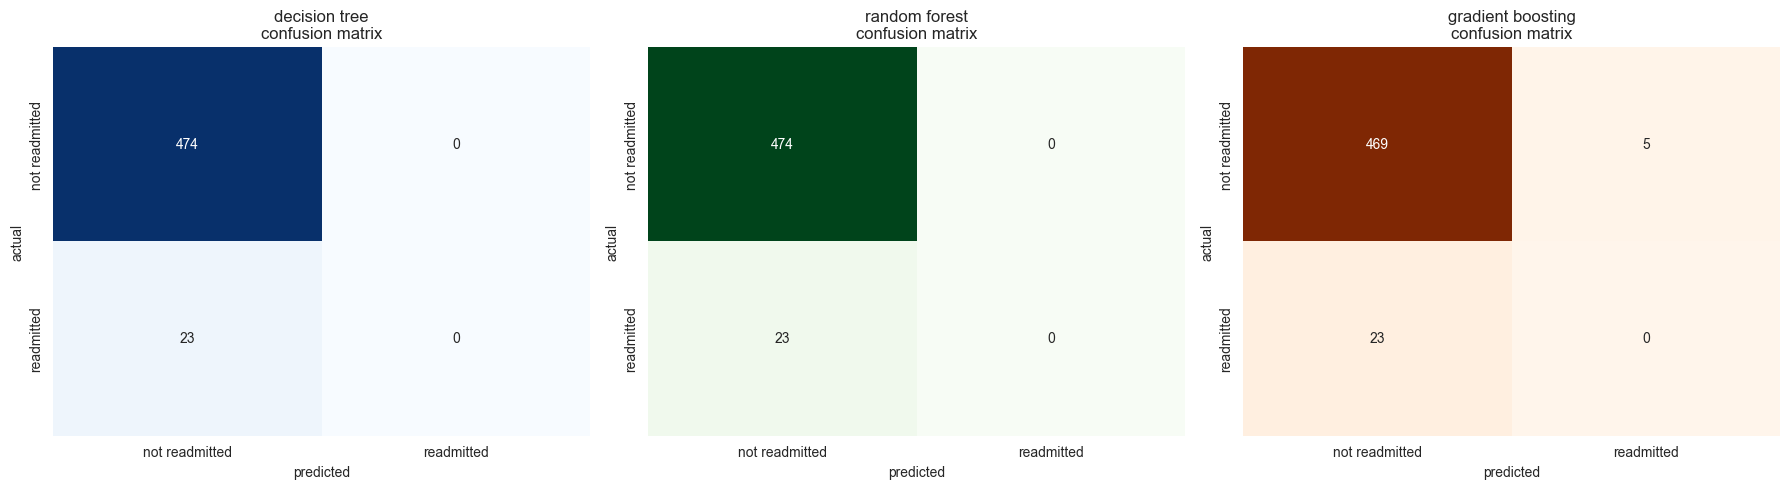

In [10]:
# generate confusion matrices
print_section_header("generating confusion matrices")

# set style
sns.set_style('white')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# decision tree
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('decision tree\nconfusion matrix')
axes[0].set_xlabel('predicted')
axes[0].set_ylabel('actual')
axes[0].set_xticklabels(['not readmitted', 'readmitted'])
axes[0].set_yticklabels(['not readmitted', 'readmitted'])

# random forest
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('random forest\nconfusion matrix')
axes[1].set_xlabel('predicted')
axes[1].set_ylabel('actual')
axes[1].set_xticklabels(['not readmitted', 'readmitted'])
axes[1].set_yticklabels(['not readmitted', 'readmitted'])

# gradient boosting
cm_gb = confusion_matrix(y_test, y_test_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False)
axes[2].set_title('gradient boosting\nconfusion matrix')
axes[2].set_xlabel('predicted')
axes[2].set_ylabel('actual')
axes[2].set_xticklabels(['not readmitted', 'readmitted'])
axes[2].set_yticklabels(['not readmitted', 'readmitted'])

plt.tight_layout()
plot_file = VISUALIZATIONS_DIR / 'classification_confusion_matrices.png'
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✓ saved: {plot_file}")
plt.show()

## 10. roc curves


                             generating roc curves                              

✓ saved: d:\Github Desktop\Python\Hospital Data Curation\visualizations\classification_roc_curves.png


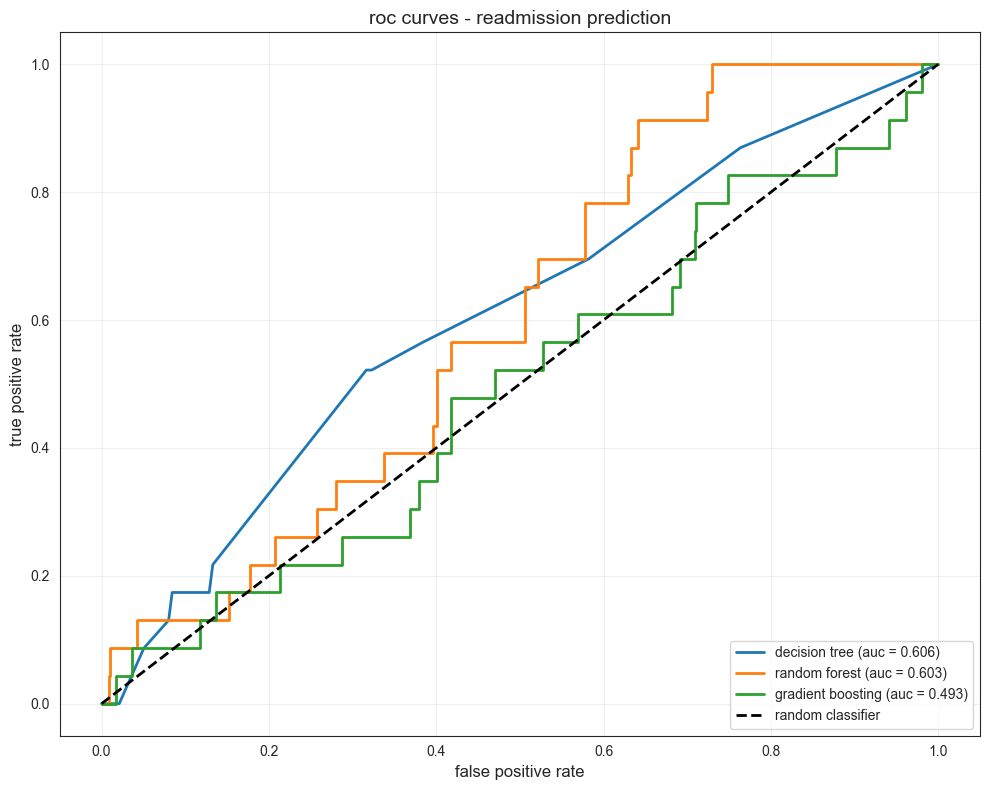

In [11]:
# generate roc curves
print_section_header("generating roc curves")

fig, ax = plt.subplots(figsize=(10, 8))

# decision tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_proba_dt)
auc_dt = roc_auc_score(y_test, y_test_proba_dt)
ax.plot(fpr_dt, tpr_dt, label=f'decision tree (auc = {auc_dt:.3f})', linewidth=2)

# random forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
auc_rf = roc_auc_score(y_test, y_test_proba_rf)
ax.plot(fpr_rf, tpr_rf, label=f'random forest (auc = {auc_rf:.3f})', linewidth=2)

# gradient boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_test_proba_gb)
auc_gb = roc_auc_score(y_test, y_test_proba_gb)
ax.plot(fpr_gb, tpr_gb, label=f'gradient boosting (auc = {auc_gb:.3f})', linewidth=2)

# diagonal line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='random classifier')

ax.set_xlabel('false positive rate', fontsize=12)
ax.set_ylabel('true positive rate', fontsize=12)
ax.set_title('roc curves - readmission prediction', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plot_file = VISUALIZATIONS_DIR / 'classification_roc_curves.png'
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✓ saved: {plot_file}")
plt.show()

## 11. feature importance visualization


                        feature importance visualization                        

✓ saved: d:\Github Desktop\Python\Hospital Data Curation\visualizations\classification_feature_importance.png


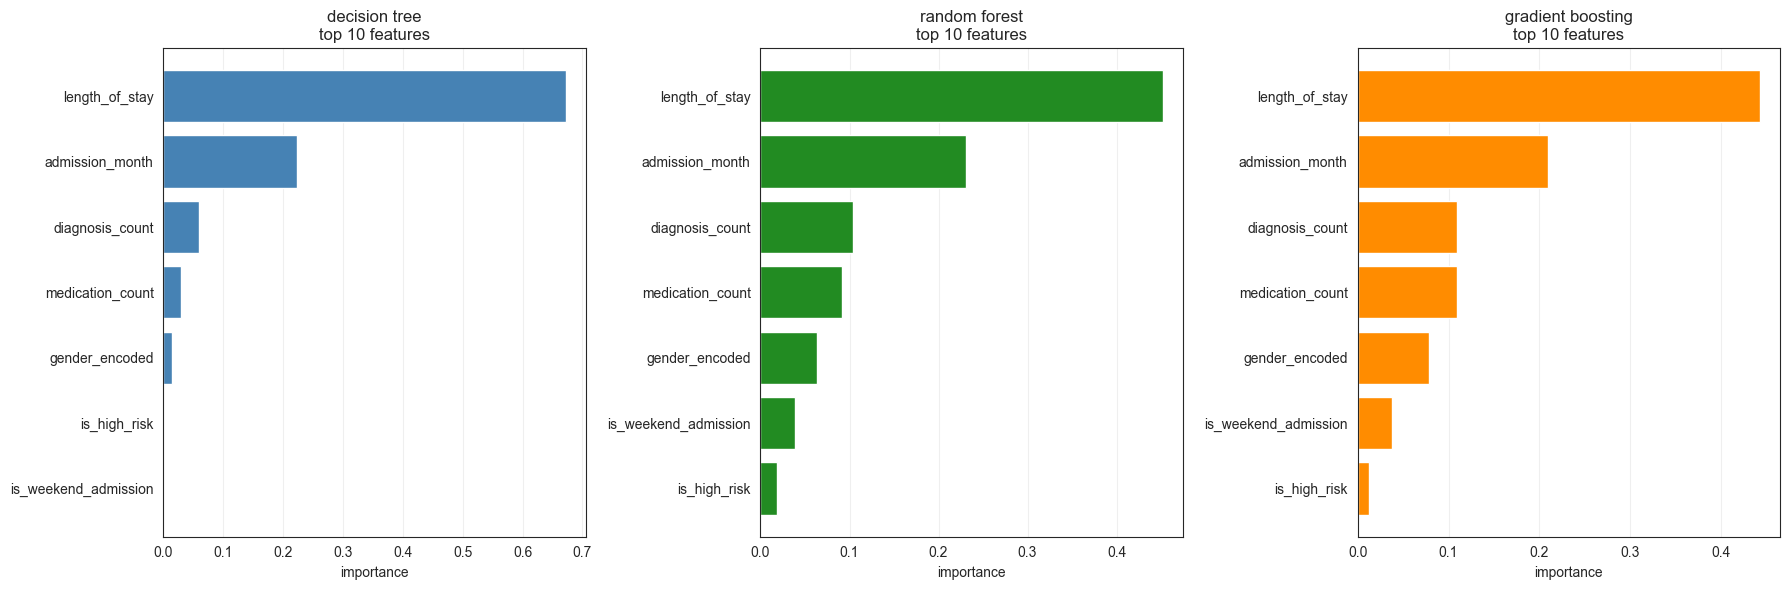

In [12]:
# visualize feature importance
print_section_header("feature importance visualization")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# decision tree
top_features_dt = feature_importance_dt.head(10)
axes[0].barh(range(len(top_features_dt)), top_features_dt['importance'], color='steelblue')
axes[0].set_yticks(range(len(top_features_dt)))
axes[0].set_yticklabels(top_features_dt['feature'])
axes[0].set_xlabel('importance')
axes[0].set_title('decision tree\ntop 10 features')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# random forest
top_features_rf = feature_importance_rf.head(10)
axes[1].barh(range(len(top_features_rf)), top_features_rf['importance'], color='forestgreen')
axes[1].set_yticks(range(len(top_features_rf)))
axes[1].set_yticklabels(top_features_rf['feature'])
axes[1].set_xlabel('importance')
axes[1].set_title('random forest\ntop 10 features')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# gradient boosting
top_features_gb = feature_importance_gb.head(10)
axes[2].barh(range(len(top_features_gb)), top_features_gb['importance'], color='darkorange')
axes[2].set_yticks(range(len(top_features_gb)))
axes[2].set_yticklabels(top_features_gb['feature'])
axes[2].set_xlabel('importance')
axes[2].set_title('gradient boosting\ntop 10 features')
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plot_file = VISUALIZATIONS_DIR / 'classification_feature_importance.png'
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✓ saved: {plot_file}")
plt.show()

## summary

classification analysis completed:

models trained:
- ✓ decision tree classifier
- ✓ random forest classifier
- ✓ gradient boosting classifier

evaluation metrics:
- accuracy, precision, recall, f1-score
- auc-roc scores
- confusion matrices
- roc curves
- feature importance rankings

healthcare implications:
- models identify patients at risk of readmission
- key risk factors: length of stay, diagnosis count, medication count, age
- can be used for proactive intervention strategies
- supports resource allocation and care planning

all models and visualizations saved to respective directories